In [1]:
import h2o
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]

import os 
from os.path import join, split

import pandas as pd

data_path = (join(
    split(os.getcwd())[0],'data'))

In [2]:
h2o.init(url='http://192.168.1.100:54321')

Checking whether there is an H2O instance running at http://192.168.1.100:54321. connected.


H2O cluster uptime:,2 mins 54 secs
H2O cluster version:,3.10.5.4
H2O cluster version age:,1 month and 5 days
H2O cluster name:,kuba
H2O cluster total nodes:,1
H2O cluster free memory:,7.099 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://192.168.1.100:54321
H2O connection proxy:,None


## Ratings table

In [3]:
filename = join(data_path, join('ml-1m', 'ratings.dat'))
pd_ratings_frame = pd.read_csv(filename, sep='%', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
pd_ratings_frame.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We'll add titles to ratings since we're going to use them as feature names later.

In [4]:
pd_movies_frame = pd.read_csv(join(data_path, 'ml-1m', 'movies.dat'), sep='%', names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

pd_all_frame = pd_ratings_frame.merge(pd_movies_frame[['MovieID', 'Title']], on='MovieID')
pd_all_frame.head()

,UserID,MovieID,Rating,Timestamp,Title
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975)


## The actual matrix that we will try to approximate

In [5]:
pd_ratings_frame = pd_all_frame.pivot(index='UserID', columns='Title', values='Rating')
pd_ratings_frame.describe()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
count,37.000000,70.000000,52.000000,303.000000,199.000000,2.000000,700.000000,565.000000,364.000000,616.000000,...,79.000000,379.000000,10.000000,109.000000,2.00000,29.000000,301.000000,2.000000,23.000000,410.000000
mean,3.027027,3.371429,2.692308,2.910891,3.713568,2.500000,3.422857,3.596460,3.046703,4.295455,...,3.632911,3.390501,3.300000,3.376147,3.50000,3.413793,3.750831,3.500000,2.521739,3.256098
std,1.092563,1.118636,1.020159,1.107760,0.878110,0.707107,0.989815,0.982103,1.098717,0.812731,...,0.787355,0.891176,1.251666,1.128659,2.12132,1.052794,1.042932,0.707107,1.122884,1.178568
min,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,2.00000,1.000000,1.000000,3.000000,1.000000,1.000000
25%,2.000000,3.000000,2.000000,2.000000,3.000000,2.250000,3.000000,3.000000,2.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.75000,3.000000,3.000000,3.250000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,4.000000,2.500000,4.000000,4.000000,3.000000,4.000000,...,4.000000,3.000000,3.000000,3.000000,3.50000,4.000000,4.000000,3.500000,3.000000,3.000000
75%,4.000000,4.000000,3.000000,4.000000,4.000000,2.750000,4.000000,4.000000,4.000000,5.000000,...,4.000000,4.000000,4.000000,4.000000,4.25000,4.000000,5.000000,3.750000,3.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,4.000000,5.000000,5.000000


In [6]:
ratings_frame = (h2o.H2OFrame(pd_ratings_frame,
                  column_types=list(map(lambda x: 'float', range(pd_ratings_frame.shape[1]))),
                  na_strings=['nan']))

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Your ratings

See the **Movies Exploration** notebook for how to search movies by title.

In [7]:
my_ratings = list(zip(*[
  ['Matrix, The (1999)', 5],
  ['Godfather, The (1972)', 4],
  ['Godfather: Part III, The (1990)', 2],
  ['Fear and Loathing in Las Vegas (1998)', 5],
  ['Trainspotting (1996)', 4],
  ['Clockwork Orange, A (1971)', 5],
  ['Full Metal Jacket (1987)', 5],
  ['Total Recall (1990)', 4],
  ['Alien (1979)', 5],
  ['GoodFellas (1990)', 4],
  ['American Psycho (2000)', 5],
  ['Home Alone 2: Lost in New York (1992)', 2],
  ['2001: A Space Odyssey (1968)', 5],
  ['Star Wars: Episode I - The Phantom Menace (1999)', 1],
  ['Conan the Barbarian (1982)', 2],
  ['Independence Day (ID4) (1996)', 1],
  ['Terminator, The (1984)', 4],
  ['Taxi Driver (1976)', 4],
  ['Titanic (1997)', 2],
  ['Pulp Fiction (1994)', 5]]))


## Your recommendations H2O Frame

In [8]:
my_ratings_df = (
  pd.DataFrame(
    data={
      'UserId': [0 for __ in range(len(my_ratings[0]))],
      'Title': my_ratings[0],
      'Rating': my_ratings[1]})
    .pivot(index='UserId', columns='Title', values='Rating')
    .reindex(columns=pd_ratings_frame.columns))
my_ratings_df.dropna(axis=1)

Title,2001: A Space Odyssey (1968),Alien (1979),American Psycho (2000),"Clockwork Orange, A (1971)",Conan the Barbarian (1982),Fear and Loathing in Las Vegas (1998),Full Metal Jacket (1987),"Godfather, The (1972)","Godfather: Part III, The (1990)",GoodFellas (1990),Home Alone 2: Lost in New York (1992),Independence Day (ID4) (1996),"Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode I - The Phantom Menace (1999),Taxi Driver (1976),"Terminator, The (1984)",Titanic (1997),Total Recall (1990),Trainspotting (1996)
UserId,,,,,,,,,,,,,,,,,,,,
0,5,5,5,5,2,5,5,4,2,4,2,1,5,5,1,4,4,2,4,4


In [9]:
pd_full_frame = pd.concat([my_ratings_df, pd_ratings_frame], axis=0)

full_h2o_frame = h2o.H2OFrame(pd_full_frame,
                            header=-1,
                            column_types=['numeric' for __ in  range(pd_full_frame.shape[1])],
                            na_strings=['nan'])

Parse progress: |█████████████████████████████████████████████████████████| 100%


## GLRM model


<img src="http://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/glrm_matrix_decomposition.png" height="138" width="419" >

### Description
GLRM models are used to approximate given matrix A using product of two low rank matrices.

GLRMs can be used to impute missing values of $ A $ (for which only some elements, for $(i, j) \in \Omega$ are given).

Concretely, $ A \approx UV $ means
that $ U, V $ are computed to minimize the objective

$E(U,V)= \sum_{i, j \in \Omega}{d(A_{i j}, U_i V^T_j)} + \frac{\lambda_1}{2} \sum_{i \in \pi_1(\Omega)}r_1(U_i) + \frac{\lambda_2}{2}  
\sum_{j \in \pi_2(\Omega)}r_2(V_j)$

That expression can be interpreted as measuring distance from $A$ to $ UV $ penalized by some regularizations $r_1, r_2$

See [Probabilistic Matrix Factorization](https://www.cs.toronto.edu/~amnih/papers/pmf.pdf) for how $E$ relates to maximum a posteriori.

### Application

Here we use exactly

$E(U, V) = \sum_{i, j \in \Omega}{(A_{i j} - U_i V^T_j)^2} + \frac{\lambda_1}{2} \sum_{i \in \pi_1(\Omega)}\left\lVert U_i \right\rVert_1 + \frac{\lambda_2}{2} \sum_{j \in \pi_2(\Omega)}\left\lVert V_j\right\rVert_1$

$\left\lVert . \right\rVert_1$ (L1 norm) is used because it provides sparser solutions than L2 norm, and also for this problem it seems to converge faster. 

We'll pick rank $k=18$ because it's the number of genres in the dataset.

In [10]:
from h2o.estimators import H2OGeneralizedLowRankEstimator

In [11]:
glrm = H2OGeneralizedLowRankEstimator(
  k=18,
  regularization_x='L1',
  regularization_y='L1',
  gamma_x=1,
  gamma_y=25,
  transform='Demean',
  init='SVD',
  max_iterations=50)

%time glrm.train(training_frame=full_h2o_frame)

glrm Model Build progress: |██████████████████████████████████████████████| 100%
CPU times: user 2.82 s, sys: 148 ms, total: 2.97 s
Wall time: 6min 24s


### Unfortunately loading GLRM models seems to crash H2O...


model_path = h2o.save_model(model=glrm, path=join(data_path, 'glrm_model'))

model_path

h2o.load_model(model_path)

## Inspecting archetypes (Y matrix)

In [12]:
%time archetypes = glrm.proj_archetypes(full_h2o_frame).as_data_frame()

CPU times: user 2.86 s, sys: 4 ms, total: 2.86 s
Wall time: 3.82 s


In [13]:
%store archetypes
# %store -r archetypes

Stored 'archetypes' (DataFrame)


In [14]:
print('Nonzero coefficients per archetype')
archetypes.apply(func=lambda r: r.astype(bool).sum(), axis=1)

Nonzero coefficients per archetype


0     2638
1     1758
2     1037
3      990
4      796
5      635
6      592
7      510
8      442
9      436
10     310
11     199
12     231
13     278
14     165
15     231
16     234
17     219
dtype: int64

In [15]:
%time reconstructed_frame = glrm.reconstruct(full_h2o_frame, reverse_transform=True)
reconstructed_pd_frame = reconstructed_frame.head().as_data_frame()

# change column names (glrm prepends 'reconstr' to them when reconstructing) 
reconstructed_pd_frame.columns = reconstructed_pd_frame.columns.str.replace('reconstr_', '')

CPU times: user 508 ms, sys: 12 ms, total: 520 ms
Wall time: 6.26 s


In [16]:
%store reconstructed_pd_frame
# %store -r reconstructed_pd_frame 

Stored 'reconstructed_pd_frame' (DataFrame)


## Print your *n* highest rated movies as suggested by model

In [17]:
n = 25

best_movies = reconstructed_pd_frame.iloc[0].sort_values(ascending=False)[:n]
best_movie_names = list(best_movies.index)
best_movies

Apple, The (Sib) (1998)                              4.666667
400 Blows, The (Les Quatre cents coups) (1959)       4.320856
American Beauty (1999)                               4.317386
12 Angry Men (1957)                                  4.295455
All About Eve (1950)                                 4.255583
Amadeus (1984)                                       4.251809
African Queen, The (1951)                            4.251656
Apocalypse Now (1979)                                4.243197
Anatomy of a Murder (1959)                           4.231156
42 Up (1998)                                         4.227273
American History X (1998)                            4.226562
Almost Famous (2000)                                 4.226358
All Quiet on the Western Front (1930)                4.194030
Aparajito (1956)                                     4.173913
Alien (1979)                                         4.160000
Annie Hall (1977)                                    4.141679
And Now 

# Visualization using dimensionality reduction

As GLRMs can be used to decompose matrices into lower-rank components, we can use them for visualization.
In this approach matrix X can give 2d embeddings for movies.

The distance in this embedding encodes how similar movies are with respect to reviews.

In [ ]:
reducer_glrm = H2OGeneralizedLowRankEstimator(
  k=2,
  regularization_x='L2',
  regularization_y='L2',
  max_iterations=10)

%time reducer_glrm.train(training_frame=reconstructed_frame)

glrm Model Build progress: |███████████████████████████████████████████████

In [ ]:
reduced_pd_frame = (reducer_glrm
  .proj_archetypes(reconstructed_frame)
  .as_data_frame())

In [ ]:
reduced_pd_frame.columns = reduced_pd_frame.columns.str.replace('reconstr_', '')
#my_rated_movies_in_reconstructed_frame = list(set(my_ratings[0]).intersection(set(reduced_pd_frame.columns)))
my_rated_movies_frame = reduced_pd_frame.loc[:, best_movie_names].T.dropna()

In [ ]:
ax = my_rated_movies_frame.plot.scatter(x=0, y=1)
my_rated_movies_frame.apply(lambda x: ax.text(*x, s=x.name), axis=1)
plt.show()

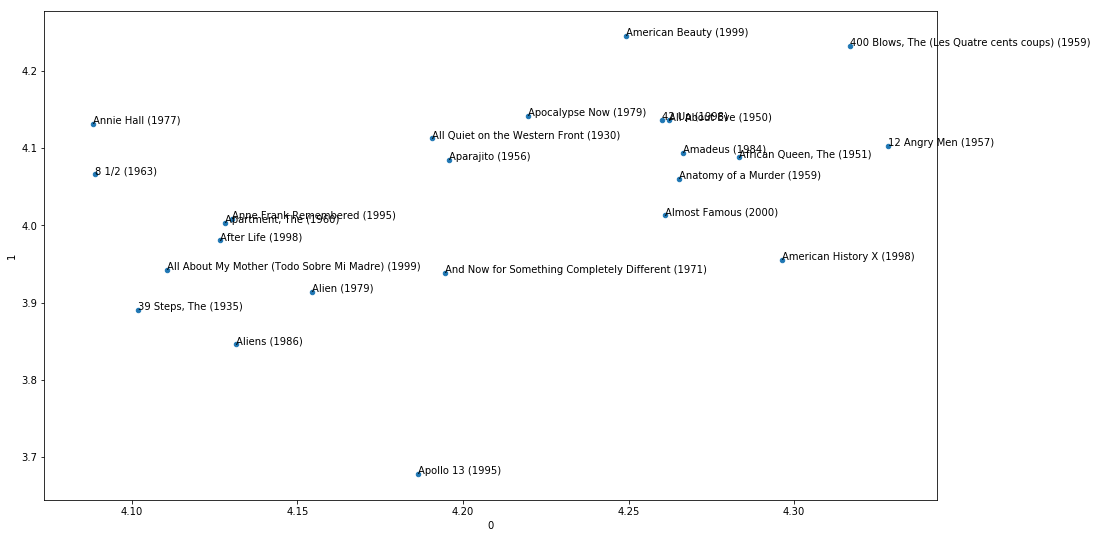

In [31]:
ax = my_rated_movies_frame.plot.scatter(x=0, y=1)
my_rated_movies_frame.apply(lambda x: ax.text(*x, s=x.name), axis=1)
plt.show()